# Denoising Models

## Imports and Definitions

In [1]:
import os
import cv2
import glob
import math
import fitz
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pytesseract as pyt

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from torch.utils.data import DataLoader

from PIL import Image, ImageOps

from diffusers import UNet2DModel, DDPMScheduler
from datasets import load_dataset, Dataset, Features, Value, Image as HfImage
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
clean = glob.glob("/teamspace/studios/this_studio/data/bronze/denoising/train/clean/*.png")
dirty = glob.glob("/teamspace/studios/this_studio/data/bronze/denoising/train/dirty/*.png")
test = glob.glob("/teamspace/studios/this_studio/data/bronze/denoising/test/*.png")

data = [
    {"image_1": c, "image_2": d} for c, d in zip(clean, dirty)
]

dataset = Dataset.from_list(data)

features = Features({
    "image_1": HfImage(),
    "image_2": HfImage()
})

dataset = dataset.cast(features)
print(dataset)

test_dataset = Dataset.from_list([{"image": c} for c in test])

features = Features({
    "image": HfImage(),
})

test_dataset = test_dataset.cast(features)
print(test_dataset)

Casting the dataset:   0%|          | 0/144 [00:00<?, ? examples/s]

Dataset({
    features: ['image_1', 'image_2'],
    num_rows: 144
})


Casting the dataset:   0%|          | 0/72 [00:00<?, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 72
})


In [3]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [4]:
def collate_train_fn(batch):
    images1 = []
    images2 = []
    for d in batch:
        img1 = transform(d['image_1'])
        img2 = transform(d['image_2'])
        images1.append(img1)
        images2.append(img2)
    return torch.stack(images1), torch.stack(images2)

def collate_test_fn(batch):
    images = []
    for d in batch:
        img = transform(d['image'])
        images.append(img)
    return torch.stack(images)

In [5]:
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_train_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_test_fn)
next(iter(train_dataloader))

(tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9922, 0.9961],
           [1.0000, 1.0000, 1.0000,  ..., 0.8745, 0.8863, 0.9255],
           [1.0000, 1.0000, 1.0000,  ..., 0.5412, 0.5725, 0.7255]]],
 
 
         [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           ...,
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],
 
 
         [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
           [1.0000

In [6]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if device.type == 'cuda':
            # Allow TensorFloat32 on matmul and convolutions
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
            torch.set_float32_matmul_precision("medium")
        return device

device = get_device()
device

device(type='cuda')

## Using a GAN

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0.0)

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [8]:
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [9]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [10]:
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

In [11]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [12]:
epochs = 15
lambda_pixel = 100

In [13]:
def discriminator_train_step(real_src, real_trg, fake_trg):
    #discriminator.train()
    d_optimizer.zero_grad()

    prediction_real = discriminator(real_trg, real_src)
    error_real = criterion_GAN(prediction_real, torch.ones(len(real_src), 1, 32, 32).to(device))
    error_real.backward()

    prediction_fake = discriminator(fake_trg.detach(), real_src)
    error_fake = criterion_GAN(prediction_fake, torch.zeros(len(real_src), 1, 32, 32).to(device))
    error_fake.backward()

    d_optimizer.step()

    return error_real + error_fake

def generator_train_step(real_src, fake_trg):
    #discriminator.train()
    g_optimizer.zero_grad()
    prediction = discriminator(fake_trg, real_src)

    loss_GAN = criterion_GAN(prediction, torch.ones(len(real_src), 1, 32, 32).to(device))
    loss_pixel = criterion_pixelwise(fake_trg, real_trg)
    loss_G = loss_GAN + lambda_pixel * loss_pixel

    loss_G.backward()
    g_optimizer.step()
    return loss_G

In [14]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    for batch in tqdm(train_dataloader):
        real_src, real_trg = [t.to(device) for t in batch]
        fake_trg = generator(real_src)

        errD = discriminator_train_step(real_src, real_trg, fake_trg)
        errG = generator_train_step(real_src, fake_trg)

    print(f"Epoch[{epoch+1}/{epochs}], ErrorD: {errD.item()}, ErrorG: {errG.item()}")

100%|██████████| 9/9 [00:02<00:00,  3.15it/s]


Epoch[1/15], ErrorD: 1.1933257579803467, ErrorG: 31.095922470092773


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Epoch[2/15], ErrorD: 0.9602986574172974, ErrorG: 9.63011646270752


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Epoch[3/15], ErrorD: 0.8876016139984131, ErrorG: 7.793808460235596


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Epoch[4/15], ErrorD: 0.7944802045822144, ErrorG: 7.976873874664307


100%|██████████| 9/9 [00:02<00:00,  4.33it/s]


Epoch[5/15], ErrorD: 0.711421549320221, ErrorG: 6.724276542663574


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


Epoch[6/15], ErrorD: 0.6665745377540588, ErrorG: 6.979935169219971


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Epoch[7/15], ErrorD: 0.6361973285675049, ErrorG: 6.378167629241943


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Epoch[8/15], ErrorD: 0.6293106079101562, ErrorG: 6.255840301513672


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Epoch[9/15], ErrorD: 0.6178531646728516, ErrorG: 6.69072151184082


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


Epoch[10/15], ErrorD: 0.5826927423477173, ErrorG: 6.336944580078125


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


Epoch[11/15], ErrorD: 0.5505033731460571, ErrorG: 6.014157295227051


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Epoch[12/15], ErrorD: 0.5586305856704712, ErrorG: 6.043949604034424


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Epoch[13/15], ErrorD: 0.554993748664856, ErrorG: 6.700632095336914


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Epoch[14/15], ErrorD: 0.5329622030258179, ErrorG: 6.258397579193115


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

Epoch[15/15], ErrorD: 0.574901819229126, ErrorG: 6.356760501861572


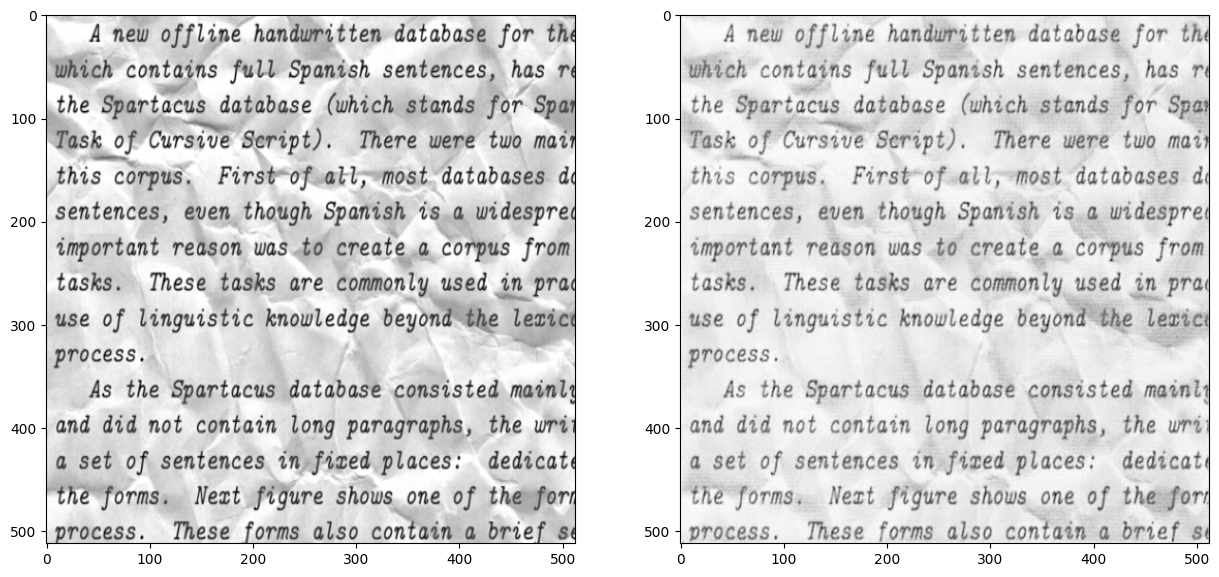

In [15]:
generator.eval()

data = next(iter(test_dataloader))
real_src = data.to(device)
fake_trg = generator(real_src)
img_sample1 = real_src[0].detach().cpu().permute(1,2,0).numpy()
img_sample2 = fake_trg[0].detach().cpu().permute(1,2,0).numpy()
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs = axs.ravel()
axs[0].imshow(img_sample1, cmap='gray')
axs[1].imshow(img_sample2, cmap='gray')
plt.show()

## Using AutoEncoder

In [16]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [17]:
def collate_train_fn(batch):
    images1 = []
    images2 = []
    for d in batch:
        img1 = transform(d['image_1'])
        img2 = transform(d['image_2'])
        images1.append(img1)
        images2.append(img2)
    return torch.stack(images1), torch.stack(images2)

def collate_test_fn(batch):
    images = []
    for d in batch:
        img = transform(d['image'])
        images.append(img)
    return torch.stack(images)

In [18]:
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_train_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_test_fn)

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder -> Downsample the image by applying convolution operations through multiple layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.GELU()
        )

        # Decoder -> Reconstruct the original image by reversing the convolution operations applied during encoding (Upsample)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1),
            nn.GELU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1),
            nn.GELU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, output_padding=0, dilation=1),
            nn.Sigmoid() # Sigmoid operation applied for the outputs which are normalized values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
autoencoder = AutoEncoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [21]:
summary(autoencoder, input_data=torch.ones(1,1,512,512, device=device))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 512, 512]          --
├─Sequential: 1-1                        [1, 128, 64, 64]          --
│    └─Conv2d: 2-1                       [1, 32, 256, 256]         832
│    └─GELU: 2-2                         [1, 32, 256, 256]         --
│    └─Conv2d: 2-3                       [1, 64, 128, 128]         51,264
│    └─GELU: 2-4                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-5                       [1, 128, 64, 64]          204,928
│    └─GELU: 2-6                         [1, 128, 64, 64]          --
├─Sequential: 1-2                        [1, 1, 512, 512]          --
│    └─ConvTranspose2d: 2-7              [1, 64, 128, 128]         131,136
│    └─GELU: 2-8                         [1, 64, 128, 128]         --
│    └─ConvTranspose2d: 2-9              [1, 32, 256, 256]         32,800
│    └─GELU: 2-10                        [1, 32, 256, 256]        

In [22]:
epochs = 10

In [23]:
autoencoder.train()

for epoch in range(epochs):
    rmse_loss = 0.0

    for batch in tqdm(train_dataloader):
        real_src, real_trg = [t.to(device) for t in batch]

        optimizer.zero_grad()
        outputs = autoencoder(real_src)
        loss = F.mse_loss(outputs, real_trg)

        rmse = torch.sqrt(loss)
        rmse_loss += rmse.mean().item()

        loss.backward()
        optimizer.step()

    print(f"Epoch[{epoch+1}/{epochs}], mse loss: {rmse_loss/len(train_dataloader)}")

100%|██████████| 9/9 [00:01<00:00,  8.70it/s]


Epoch[1/10], mse loss: 0.34533948368496364


100%|██████████| 9/9 [00:01<00:00,  8.92it/s]


Epoch[2/10], mse loss: 0.2306600825654136


100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


Epoch[3/10], mse loss: 0.19629066520267063


100%|██████████| 9/9 [00:01<00:00,  8.39it/s]


Epoch[4/10], mse loss: 0.1946481300724877


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


Epoch[5/10], mse loss: 0.19237607220808664


100%|██████████| 9/9 [00:01<00:00,  8.75it/s]


Epoch[6/10], mse loss: 0.18899018896950615


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


Epoch[7/10], mse loss: 0.1871845308277342


100%|██████████| 9/9 [00:01<00:00,  8.84it/s]


Epoch[8/10], mse loss: 0.18250276645024618


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


Epoch[9/10], mse loss: 0.1816735847128762


100%|██████████| 9/9 [00:01<00:00,  8.82it/s]

Epoch[10/10], mse loss: 0.17633627520667183


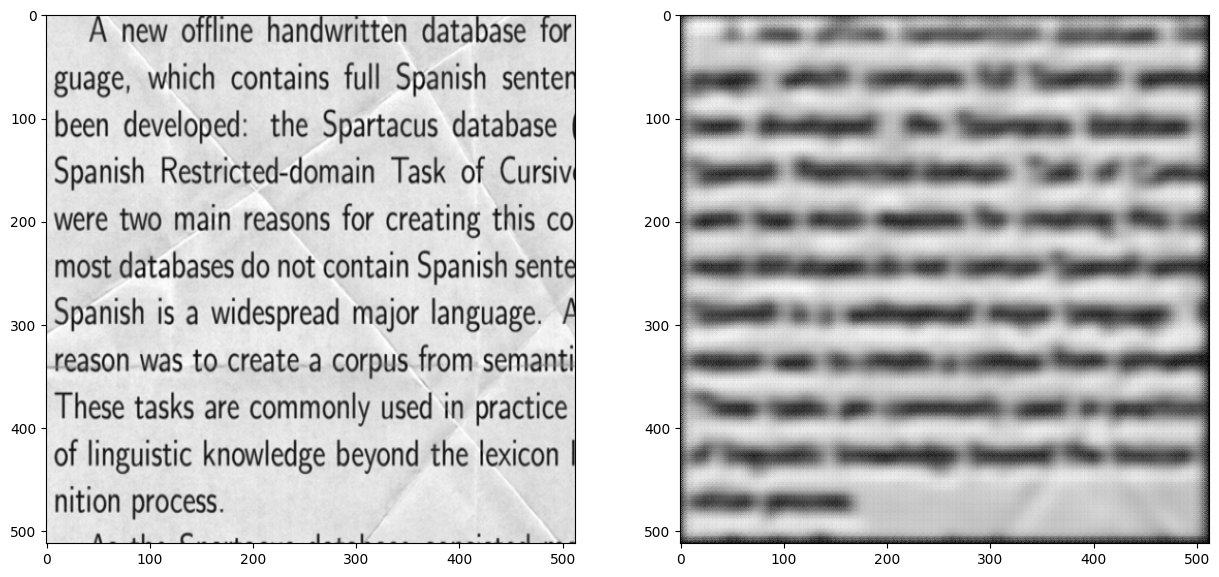

In [24]:
autoencoder.eval()

data = next(iter(test_dataloader))
real_src = data.to(device)
fake_trg = autoencoder(real_src)
img_sample1 = real_src[0].detach().cpu().permute(1,2,0).numpy()
img_sample2 = fake_trg[0].detach().cpu().permute(1,2,0).numpy()
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs = axs.ravel()
axs[0].imshow(img_sample1, cmap='gray')
axs[1].imshow(img_sample2, cmap='gray')
plt.show()

## Diffusion Model

In [7]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [8]:
def collate_train_fn(batch):
    images1 = []
    images2 = []
    for d in batch:
        img1 = transform(d['image_1'])
        img2 = transform(d['image_2'])
        images1.append(img1)
        images2.append(img2)
    return torch.stack(images1), torch.stack(images2)

def collate_test_fn(batch):
    images = []
    for d in batch:
        img = transform(d['image'])
        images.append(img)
    return torch.stack(images)

In [9]:
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_train_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_test_fn)

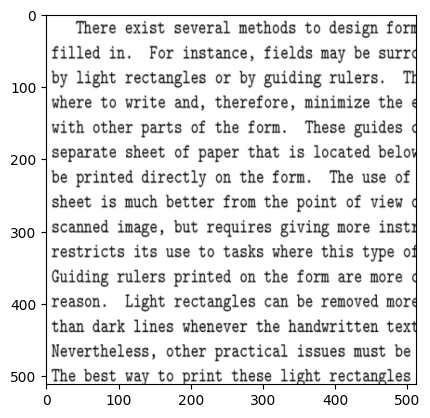

In [10]:
img1, img2 = next(iter(train_dataloader))
real_img = img1[0].cpu().permute(1,2,0).numpy()
plt.imshow(real_img, cmap='gray')

In [11]:
from diffusers.models.unets.unet_2d import UNet2DModel
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler


diff = UNet2DModel(
    sample_size=512,
    in_channels=1,
    out_channels=1,
    block_out_channels=(32, 32),
    down_block_types=("DownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D")
).to(device)

scheduler = DDPMScheduler(num_train_timesteps=25)
optimizer = torch.optim.Adam(diff.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [12]:
epochs = 50

In [13]:
diff.train()

for epoch in range(epochs):
    rmse_loss = 0.0
    
    for batch in tqdm(train_dataloader):
        clean_img, noise_img = [t.to(device) for t in batch]

        noise = torch.randn_like(noise_img)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (noise_img.shape[0],), device=device).long()
        noisy = scheduler.add_noise(noise_img, noise, timesteps)

        optimizer.zero_grad()
        pred = diff(noisy, timesteps).sample
        loss = F.mse_loss(pred, clean_img)

        loss.backward()
        optimizer.step()

        rmse = torch.sqrt(loss)
        rmse_loss += rmse.mean().item()

    print(f"Epoch[{epoch+1}/{epochs}], mse loss: {rmse_loss/len(train_dataloader)}")

100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[1/50], mse loss: 0.9660413463910421


100%|██████████| 9/9 [01:17<00:00,  8.63s/it]


Epoch[2/50], mse loss: 0.8815049793985155


100%|██████████| 9/9 [01:17<00:00,  8.64s/it]


Epoch[3/50], mse loss: 0.8031610912746854


100%|██████████| 9/9 [01:17<00:00,  8.63s/it]


Epoch[4/50], mse loss: 0.7237214777204726


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[5/50], mse loss: 0.6400976975758871


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[6/50], mse loss: 0.564026501443651


100%|██████████| 9/9 [01:17<00:00,  8.63s/it]


Epoch[7/50], mse loss: 0.5087374978595309


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[8/50], mse loss: 0.46276283264160156


100%|██████████| 9/9 [01:17<00:00,  8.66s/it]


Epoch[9/50], mse loss: 0.421422799428304


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[10/50], mse loss: 0.38439086741871303


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[11/50], mse loss: 0.35339047180281746


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[12/50], mse loss: 0.3238498833444383


100%|██████████| 9/9 [01:17<00:00,  8.63s/it]


Epoch[13/50], mse loss: 0.29203615585962933


100%|██████████| 9/9 [01:17<00:00,  8.64s/it]


Epoch[14/50], mse loss: 0.26552824841605294


100%|██████████| 9/9 [01:17<00:00,  8.60s/it]


Epoch[15/50], mse loss: 0.23897391060988107


100%|██████████| 9/9 [01:17<00:00,  8.61s/it]


Epoch[16/50], mse loss: 0.22272937993208566


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[17/50], mse loss: 0.20014659066994986


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[18/50], mse loss: 0.18597458799680075


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[19/50], mse loss: 0.17089907162719303


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[20/50], mse loss: 0.16121486657195622


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[21/50], mse loss: 0.1455485075712204


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[22/50], mse loss: 0.14285056127442253


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[23/50], mse loss: 0.13248999416828156


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[24/50], mse loss: 0.12865756783220503


100%|██████████| 9/9 [01:17<00:00,  8.61s/it]


Epoch[25/50], mse loss: 0.12184088263246748


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[26/50], mse loss: 0.12264331512980992


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[27/50], mse loss: 0.11585137993097305


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[28/50], mse loss: 0.11395366489887238


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[29/50], mse loss: 0.11269159449471368


100%|██████████| 9/9 [01:17<00:00,  8.66s/it]


Epoch[30/50], mse loss: 0.11002106716235478


100%|██████████| 9/9 [01:17<00:00,  8.66s/it]


Epoch[31/50], mse loss: 0.11466209673219258


100%|██████████| 9/9 [01:17<00:00,  8.66s/it]


Epoch[32/50], mse loss: 0.1124223851495319


100%|██████████| 9/9 [01:17<00:00,  8.63s/it]


Epoch[33/50], mse loss: 0.11288669622606701


100%|██████████| 9/9 [01:17<00:00,  8.60s/it]


Epoch[34/50], mse loss: 0.10458097855250041


100%|██████████| 9/9 [01:17<00:00,  8.61s/it]


Epoch[35/50], mse loss: 0.10628127637836668


100%|██████████| 9/9 [01:17<00:00,  8.66s/it]


Epoch[36/50], mse loss: 0.11054636869165632


100%|██████████| 9/9 [01:17<00:00,  8.66s/it]


Epoch[37/50], mse loss: 0.1059823226597574


100%|██████████| 9/9 [01:17<00:00,  8.64s/it]


Epoch[38/50], mse loss: 0.10928920408089955


100%|██████████| 9/9 [01:17<00:00,  8.63s/it]


Epoch[39/50], mse loss: 0.10408817231655121


100%|██████████| 9/9 [01:17<00:00,  8.63s/it]


Epoch[40/50], mse loss: 0.10436004979742898


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[41/50], mse loss: 0.1033487684196896


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[42/50], mse loss: 0.10814729581276576


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[43/50], mse loss: 0.10762683219379848


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[44/50], mse loss: 0.10298420240481694


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[45/50], mse loss: 0.105204991168446


100%|██████████| 9/9 [01:18<00:00,  8.67s/it]


Epoch[46/50], mse loss: 0.10171240733729468


100%|██████████| 9/9 [01:17<00:00,  8.66s/it]


Epoch[47/50], mse loss: 0.10570011701848772


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]


Epoch[48/50], mse loss: 0.10634735061062707


100%|██████████| 9/9 [01:17<00:00,  8.62s/it]


Epoch[49/50], mse loss: 0.09964922070503235


100%|██████████| 9/9 [01:17<00:00,  8.65s/it]

Epoch[50/50], mse loss: 0.10348894529872471


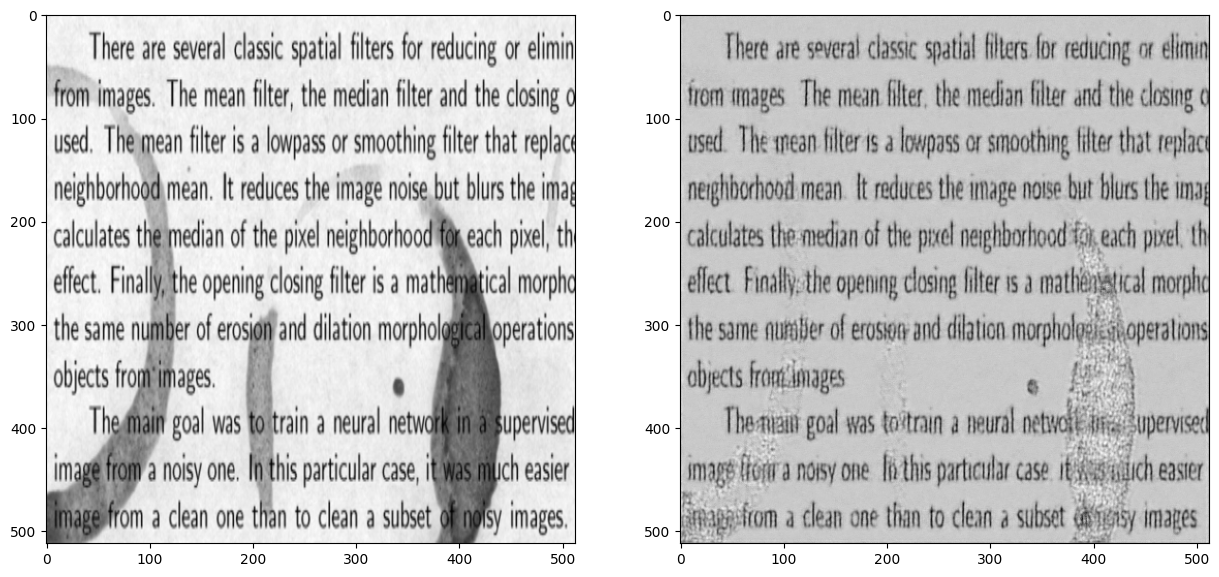

In [14]:
diff.eval()

data = next(iter(test_dataloader))
clean_img, noise_img = [t.to(device) for t in batch]
noise = torch.randn_like(noise_img)
timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (noise_img.shape[0],), device=device).long()
noisy = scheduler.add_noise(noise_img, noise, timesteps)
clean_pred = diff(noisy, timesteps).sample
img_sample1 = noise_img[0].detach().cpu().permute(1,2,0).numpy()
img_sample2 = clean_pred[0].detach().cpu().permute(1,2,0).numpy()
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs = axs.ravel()
axs[0].imshow(img_sample1, cmap='gray')
axs[1].imshow(img_sample2, cmap='gray')
plt.show()